# FunSPICE


## Overview 

FunSPICE is a python based linear laplace domain symbolic SPICE style circuit solver. 

The overall useage flow for FunSPICE is:

Draw Circuit -> Label Nodes (0, 1, ..) -> Type Netlist -> FunSPICE -> Results

Netlists are represented by an array of python dictionaries describing each elements. The element dictionaries contain the element information such as the node connections and element model parameters. Here is an example netlist for a simple voltage divider circuit:
<br>
<img src="rdiv.png" style="float: left;">

In [1]:
netlist = [
{'type':'V', 'k':1, 'j':0, 'val':'V_i'},
{'type':'R', 'k':1, 'j':2, 'val':'R_1'},
{'type':'R', 'k':2, 'j':0, 'val':'R_2'}
]

This netlist dictionary array is passed into the FunSPICE class constructor for it to parse, build the circuit matrix, and solve it. FunSPICE stores the results in a results array, where each voltage and current can be accessed via string keys. To get a list of all the available results use the print_results() function. The voltage keys match the node number in the circuit, ie v1 = 1. The currents are slightly cryptic and require a deeper understanding of how the spice matrix works internally to connect to the circuit. Note that not every element in the circuit requires a current variable in order to solve the ciruit. For example resistors don't need to track currents, but a voltage source does. That being said, the way the currents are labeled depends on the element type and where it lies in the netlist dictionary array. If a "vin" voltage source is the first element in the netlist, then i1 will always be the current flowing from k-j through that source.

In [2]:
from FunSPICE import *
init_printing()
funspice = FunSPICE(netlist)
funspice.print_results()

****************************************
******        RESULTS          *********
****************************************
v1 = 
Vᵢ
****************************************
v2 = 
 R₂⋅Vᵢ 
───────
R₁ + R₂
****************************************
i1 = 
  -Vᵢ  
───────
R₁ + R₂
****************************************


FunSPICE uses the SymPy symbolic mathematics library at it's core, so you can use it's methods on the results for differentiating, integrating, limits, etc. The init_printing() function above is a SymPy method that enables jupyter to display pretty Latex equations.

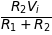

In [3]:
Vo = funspice.results['v2']
Vo

In [4]:
zin = funspice.results['v1']/(-funspice.results['i1'])
zin

### Supported Elements
<ul>
    <li>Voltage Source (V)</li> 
    <li>Current Source (I)</li> 
    <li>Resistor (R)</li> 
    <li>Inductor (L)</li> 
    <li>Capacitor (C)</li> 
    <li>Voltage Controlled Voltage Source (E)</li> 
    <li>Voltage Controlled Current Source (G)</li> 
    <li>Current Controlled Current Source (F)</li> 
    <li>Current Controlled Voltage Source (H)</li> 
    <li>Ideal 1:N Transformer (X)</li> 
    <li>MOSFET SSM with variable ro, gm, cgd, cgs (M)</li>
    <li>BJT SSM with variable ro, beta, gm, cbe, cbc (B)</li>
    <li>OPAMP with infinite or defined gain function (O)</li>
</ul>


### Supported Features
<ul>
    <li>Symbolic and numeric AC vector circuit analysis</li>
    <li><b>print_results():</b> print all circuit matrix results</li>
    <li><b>polezeros(tf):</b> extract pole and zero frequencies from a transfer function (tf) equation</li>
    <li><b>sens(function, var):</b> compute the sensitivity of function with respect to the symbol var</li>
    <li><b>abeta(tf):</b> extracts the open loop gain and feedback factor from a closed loop tf.</li>
</ul>

### Future Development Wish List
<ul>
    <li>Add BULK terminal to MOSFET model</li>
    <li>Current Conveyor/Transimpedance Amplifier AC model (Z)</li>
    <li>Current probe (A)</li>
    <li>Named node ('vi' as opposed to 1)</li>
    <li>Named current results by element/probe ('iv1')</li>
    <li>Specialized AC analysis (S-Param, Noise Figure, PSRR, etc.)</li>
    <li>Create example circuits that can't be solved with AC methods and thus don't work with FunSPICE (non-linear and translinear circuits)</li></ul>

### Future Analysis Ideas

<ul>
    <li><b>S-Parameters</b></li>
    <li>Put port elements in the circuit, and it solves S11, S21, etc in terms of circuit variables. Even and odd mode impedance analysis would be nice too. </li>
    <li><b>Noise Figure</b></li>
    <li>Put port elements in the circuit and it solves for NF in terms of the circuit variables for each device and noise source in the circuit (automatically include fet gate noise, bjt shot noise, op amp input referred noise, etc. symbolically)</li>
    <li><b>PSSR</b></li>
        <li>Solve PSRR transfer functions for each defined power rail to a specified node in the circuit (Vo for example) </li>
    <li><b>Differential and CM</b> </li>
    <li>Put in a differential source and it solves for Av_d, Av_cm, CMRR, Zin_d, Zin_cm </li>
</ul>


## FunSPICE Example Usage
## Three Input Inverting Voltage Adder with Op Amp (infinite gain, infinite bandwidth) 
### Circuit Diagram
<img src="adder.png" style="float: left;">
### Fun Experiment
Try changing the gain value of the opamp from infinity to A_v and re-run the cells to see how the equations change.

In [5]:
netlist = [
{'type':'V', 'k':1, 'j':0, 'val':'V_1'},
{'type':'V', 'k':2, 'j':0, 'val':'V_2'},
{'type':'V', 'k':3, 'j':0, 'val':'V_3'},
{'type':'R', 'k':1, 'j':4, 'val':'R_1'},
{'type':'R', 'k':2, 'j':4, 'val':'R_2'},
{'type':'R', 'k':3, 'j':4, 'val':'R_3'},
{'type':'O', 'p':0, 'n':4, 'o':5, 'val':'inf'},
{'type':'R', 'k':4, 'j':5, 'val':'R_f'}
]

funspice = FunSPICE(netlist)
Vo = funspice.results['v5']

### Vo

In [6]:
Vo

## Op Amp (finite gain, finite bandwidth) based Non-Inverting Amplifier
### Circuit Diagram
<img src="noninvamp.png" style="float: left;">
### Fun Experiment
Try changing the gain value of the opamp from the 1rst order lowpass transfer function (A_0/(1+s/w_b)) to inf and re-run the cells to see the ideal gain we know and love.

In [7]:
netlist = [
{'type':'V', 'k':1, 'j':0, 'val':'V_i'},
{'type':'O', 'p':1, 'n':2, 'o':3, 'val':'A_0/(1+s/w_b)'},
{'type':'R', 'k':2, 'j':0, 'val':'R_a'},
{'type':'R', 'k':2, 'j':3, 'val':'R_f'}
]

funspice = FunSPICE(netlist)
Vo = funspice.results['v3']
Vi = Symbol("V_i")
Gain = Vo/Vi

### Gain

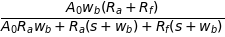

In [8]:
Gain

### DC Gain

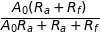

In [9]:
s = Symbol("s")
Gain_DC = simplify(Gain.subs(s,0))
Gain_DC

### Poles and Zeros

In [10]:
zeros, poles = poleszeros(Gain)

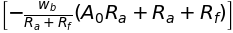

In [11]:
poles

In [12]:
zeros

## Transformer Circuit
### Circuit Diagram
<img src="xfrmcir.png" style="float: left;">

In [13]:
netlist = [
{'type':'V', 'k':1, 'j':0, 'val':'V_i'},
{'type':'R', 'k':1, 'j':2, 'val':'R_S'},
{'type':'X', 'p1':2, 'n1':0, 'p2':3, 'n2':0, 'val':'n'},
{'type':'R', 'k':3, 'j':0, 'val':'R_L'}
]
funspice = FunSPICE(netlist)
v2 = funspice.results['v2']
v3 = funspice.results['v3']
iin = -funspice.results['i1']
zin = v2/iin
Vo = v3

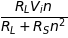

In [14]:
simplify(Vo)

In [15]:
simplify(zin)

## Bipolar Current Mirror

### Circuit Diagram
<img src="npnmirror.png" style="float: left;">

In [16]:
netlist = [
{'type':'V', 'k':4, 'j':0, 'val':0}, #vout short
{'type':'I', 'k':0, 'j':1, 'val':'I_i'}, # Ii input current
{'type':'B', 'c':1, 'b':1, 'e':2, 'ro':'inf', 'beta':'beta_0', 'gm':'gm_n', 'cbe':'0', 'cbc':0}, #B1
{'type':'R', 'k':2, 'j':0, 'val':'R_e'}, #Re1
{'type':'B', 'c':4, 'b':1, 'e':3, 'ro':'inf', 'beta':'beta_0', 'gm':'gm_n', 'cbe':'0', 'cbc':0}, #B2
{'type':'R', 'k':3, 'j':0, 'val':'R_e'}, #Re2
{'type':'B', 'c':4, 'b':1, 'e':5, 'ro':'inf', 'beta':'beta_0', 'gm':'gm_n', 'cbe':'0', 'cbc':0}, #B3
{'type':'R', 'k':5, 'j':0, 'val':'R_e'} #Re3
]

funspice = FunSPICE(netlist)
Io = -funspice.results['i1']
Ii = Symbol("I_i")
Gain = simplify(Io/Ii)

### Gain

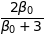

In [17]:
Gain

### Limit(Gain, beta0 -> inf)

In [18]:
beta0 = Symbol("beta_0")
limit(Gain, beta0, oo)

## Series Voltage Feedback with Noise
### Circuit Diagram
<img src="e_cir.png">

In [19]:
netlist = [
{'type':'V', 'k':1, 'j':0, 'val':'V_i'},
{'type':'E', 'k':3, 'j':4, 'p':1, 'q':2, 'val':'A_v'},
{'type':'V', 'k':4, 'j':0, 'val':'N_o'},  
{'type':'E', 'k':2, 'j':0, 'p':3, 'q':0, 'val':'B'}
]
funspice = FunSPICE(netlist)
Vo = funspice.results['v3']

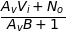

In [20]:
simplify(Vo)

## Op Amp (finite gain) Bandpass Filter
### Circuit Diagram
<img src="bpfilt.png">

### Fun Experiment
Try changing the gain value of the opamp from infinity to A_v and re-run the cells to see how the equations change.

In [21]:
netlist = [
{'type':'V', 'k':1, 'j':0, 'val':'V_i'},
{'type':'R', 'k':1, 'j':2, 'val':'R_1'},
{'type':'C', 'k':2, 'j':3, 'val':'C_1'},
{'type':'R', 'k':3, 'j':4, 'val':'R_2'},
{'type':'C', 'k':3, 'j':4, 'val':'C_2'},
{'type':'O', 'p':0, 'n':3, 'o':4, 'val':'inf'}
]

funspice = FunSPICE(netlist)
Vo = funspice.results['v4']
Vi = Symbol("V_i")
Gain = Vo/Vi

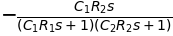

In [22]:
simplify(Gain)

### Poles and Zeros

In [23]:
zeros, poles = poleszeros(Gain)

In [24]:
poles

In [25]:
zeros